# Bayesian Inference

This tutorial accompanies the "Introduction to Bayesian Inference" video in the NMedIA "Essentials of Medical Imaging Analysis" course. Bayesian inference is commonly used in modelling scenarios. The idea of this tutorial is to allow you to adjust different parameters in a problem where Bayesian inference is used for model fitting. We hope this will help you build intuition and assist you if you come across algorithms using Bayesian inference in practice.

To use this notebook, hit "Cell" and then "Run All" to run all of the cells. This will run the cell below which will hide the code that produces the outputs. (If you do want to see the code, you can click the toggle which will appear below which says "Click here to show/hide code.")

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show/hide code."></form>''')

In [2]:
%matplotlib notebook

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual, GridspecLayout
import ipywidgets as widgets
from IPython.display import display

In [4]:
# define some plotting functions
colours = {"ground_truth": "#4daf4a",
           "empirical": "#f781bf",
           "exact": "#377eb8",
           "approx": "#ff7f00",
           "prior": "#a65628"}
linestyles = {"ground_truth": "solid",
              "empirical": "dashdot",
              "exact": "dashed",
              "approx": "dotted",
              "prior": (0, (3, 5, 1, 5, 1, 5))}

def get_contours(x, mu, std):
    return (1 / (std * np.sqrt(np.pi))) * np.exp(-0.5 * np.square((x - mu) / std))

def plot_contours(ax, *args):
    for arg in args:
        x, y, c, l, ls = arg
        ax.plot(x, y, color=c, linestyle=ls, label=l)
        ax.legend(loc='upper right')

def plot_tramlines(ax, *args):
    for arg in args:
        mu, std, label = arg
        ax.axvline(mu - 2*std, color=colours[label], linestyle="--")
        ax.axvline(mu, color=colours[label])
        ax.axvline(mu + 2*std, color=colours[label], linestyle="--")

def get_x_range(*args):
    xmin = None
    xmax = None
    for arg in args:
        mu, std = arg
        l = mu - 3 * std
        if xmin:
            if l < xmin:
                xmin = l
        else:
            xmin = l
        u = mu + 3 * std
        if xmax:
            if u > xmax:
                xmax = u
        else:
            xmax = u
    return np.linspace(xmin, xmax, 1000)

# Example Scenario

Like all good tutorials, we'll assume our data was sampled from a Normal distribution. Our goal is to estimate the parameters of the Normal distribution from which our data was sampled, i.e. the mean and standard deviation.

## Sample some data

Below, we sample some data from a 1-dimensional Normal distribution and plot their histogram. Feel free to play with the value of the mean, $\mu$, and the standard deviation, $\sigma$, and see how this changes the data.

Things to note/try:
* For large values of $N$, you should see the typical bell-curve shape of the Normal distribution.
* If you change $\mu$, the centre of the data will move (i.e. the centre value on the $x$ axis will move).
* If you increase $\sigma$, the spread of the data will increase (i.e. the range on the $x$ axis will increase).

<IPython.core.display.Javascript object>


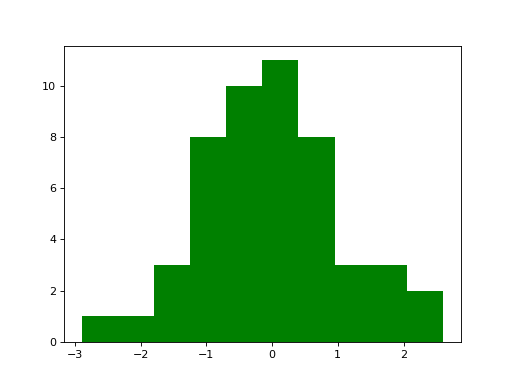

interactive(children=(IntSlider(value=50, continuous_update=False, description='N', min=5, step=5), IntSlider(…

In [5]:
def get_data(N, mu, std):
    w.value = np.random.normal(mu, std, [N])

def display_data(ax, data):
    ax.hist(w.value, bins=10, color='g', align='left')
    plt.show()
    
def update_plot(change):
    ax0.clear()
    display_data(ax0, data=w.value)

# set up figure
fig0, ax0 = plt.subplots(num=0)

# get our widgets
N = widgets.IntSlider(value=50, min=5, max=100, step=5, description="N", continuous_update=False)
mu = widgets.IntSlider(value=0, min=-10, max=10, step=1, description="$\mu$", continuous_update=False)
std = widgets.FloatSlider(value=1., min=0.1, max=10, step=0.1, description="$\sigma$", continuous_update=False)

w = interactive(get_data, N=N, mu=mu, std=std);
display(w);

# display our data
display_data(ax0, w.value);

# watch for a change in our widgets. This is messy, is there a nicer way to do it?
[w.children[n].observe(update_plot, 'value') for n in range(len(w.children))];

# Empirical Mean and Standard Deviation

The first thing we might think to do is simply get the mean and the standard deviation of our observations.

If you play around with the values of the parameters $N$, $\mu$ and $\sigma$ you should notice:
* Increasing the number of observations, $N$, drives our empirical approximation closer to the ground truth;
* Similarly, deacreasing the standard deviation, $\sigma$, of our distribution generally results in a better approximation;
* If we have a small number of observations, $N$, and a large standard deviation, $\sigma$, our empirical approximation can be quite poor. We don't have any measure of confidence in our estimate however so this can be difficult to diagnose in practice.

interactive(children=(IntSlider(value=50, continuous_update=False, description='N', min=5, step=5), IntSlider(…

<IPython.core.display.Javascript object>


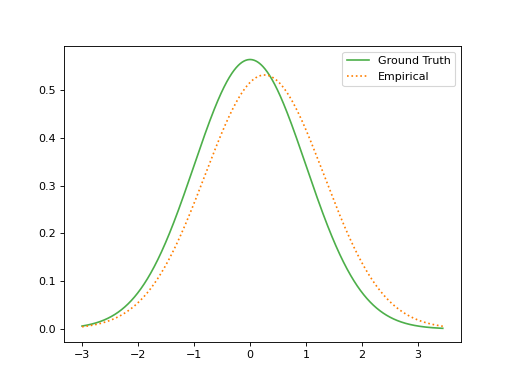

In [6]:
def update_empirical_contour(change):
    emp_mean, emp_std = [np.mean(w.value), np.std(w.value)]
    x = get_x_range((mu.value, std.value), (emp_mean, emp_std))
    data_contour = get_contours(x, mu.value, std.value)
    emp_contour = get_contours(x, emp_mean, emp_std)
    ax1.clear()
    plot_contours(ax1,
                  (x, data_contour, colours["ground_truth"], "Ground Truth", linestyles["ground_truth"]),
                  (x, emp_contour, colours["approx"], "Empirical", linestyles["approx"]))

emp_mean, emp_std = [np.mean(w.value), np.std(w.value)]
display(w);

fig1, ax1 = plt.subplots(num=1)
x = get_x_range((mu.value, std.value), (emp_mean, emp_std))
data_contour = get_contours(x, mu.value, std.value)
emp_contour = get_contours(x, emp_mean, emp_std)
plot_contours(ax1,
              (x, data_contour, colours["ground_truth"], "Ground Truth", linestyles["ground_truth"]),
              (x, emp_contour, colours["approx"], "Empirical", linestyles["approx"]))
[w.children[n].observe(update_empirical_contour, 'value') for n in range(len(w.children))];

# Bayesian Inference

Suppose we also want to express our confidence in our parameter estimates, i.e. how confident are we in our estimate of the mean, $\mu$? The simple method above can't do this. It only gives us estimates of $\mu$ and $\sigma$.

It also doesn't let us include prior knowledge about the ground truth distribution. This prior knowledge can include biophysical "soft" constraints where we have a reasonable suspicion that the value of a parameter lies within certain bounds or spatial regularisation where we believe our signal follows a certain pattern in space.

## Set up our prior

In the following model, we have 4 parameters. These are:
* $m_0$ = Our prior knowledge of the mean;
* $v_0$ = Our prior confidence in our prior mean;
* $\beta_0$ = Our prior on the mean of the precision;
* $\sigma_0$ = How confident we are in our prior on the variance.

If you vary the values of the prior mean, $m_0$, and prior variance, $\beta_0$, away from the values of the parameters of the data distribution, $\mu$ and $\sigma$, you will notice that the shape of the prior no longer matches the shape of the data distribution. This isn't necessarily a bad thing. We can use large variances on those prior values to indicate that we aren't particularly confident in their values, which will allow them to vary more freely when fitting the model. This is known as an uninformative prior. With sufficient data, the posterior distribution should still converge to the correct answer. If our prior is wrong and we are over-confident in it, we will need more data to converge to the correct answer. We'll see examples of these scenarios later.

<IPython.core.display.Javascript object>


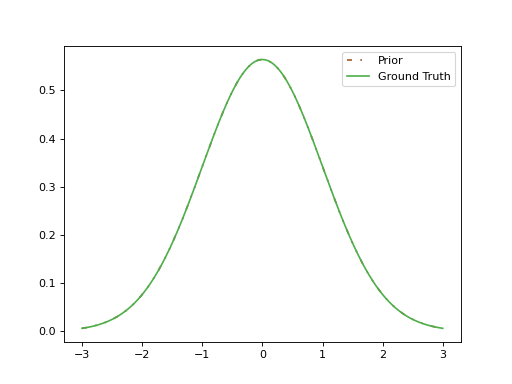

GridspecLayout(children=(interactive(children=(IntSlider(value=50, continuous_update=False, description='N', m…

In [7]:
def print_prior(m0, v0, beta_mean0, beta_var0):
    print(m0, v0, beta_mean0, beta_var0)

def update_prior_contour(change):
    x = get_x_range((m0.value, beta_mean0.value), (mu.value, std.value))
    data_contour = get_contours(x, mu.value, std.value)
    prior_contour = get_contours(x, m0.value, beta_mean0.value)
    ax2.clear()
    plot_contours(ax2,
                  (x, data_contour, colours["ground_truth"], "Ground Truth", linestyles["ground_truth"]),
                  (x, prior_contour, colours["prior"], "Prior", linestyles["prior"]))

# create widgets for the prior values of our NormalGamma distribution
m0 = widgets.IntSlider(value=0, min=-10, max=10, step=1, description="$m_0$", continuous_update=False)
v0 = widgets.IntSlider(value=1000, min=1, max=1000, step=1, description="$v_0$", continuous_update=False)
beta_mean0 = widgets.IntSlider(value=1, min=1, max=100, step=1, description="Beta mean", continuous_update=False)
beta_var0 = widgets.IntSlider(value=1000, min=1, max=1000, step=1, description="Beta var", continuous_update=False)
prior_widget = interactive(print_prior, m0=m0, v0=v0, beta_mean0=beta_mean0, beta_var0=beta_var0)

fig2, ax2 = plt.subplots(num=2)
x = get_x_range((m0.value, beta_mean0.value), (mu.value, std.value))
prior_contour = get_contours(x, m0.value, beta_mean0.value)
data_contour = get_contours(x, mu.value, std.value)
plot_contours(ax2,
              (x, prior_contour, colours["prior"], "Prior", linestyles["prior"]),
              (x, data_contour, colours["ground_truth"], "Ground Truth", linestyles["ground_truth"]))

grid = GridspecLayout(1, 2)
grid[0, 0] = w
grid[0, 1] = prior_widget
display(grid);

[w.children[n].observe(update_prior_contour, 'value') for n in range(len(w.children))];
[prior_widget.children[n].observe(update_prior_contour, 'value') for n in range(len(prior_widget.children))];

## Exact Solution

In a lot of cases, inferring the posterior distribution of our parameters is an intractable problem. In the case we're considering here however, we can find the exact solution. The solid verticle line indicates the mean of our posterior distribution and the dashed verticle lines indicate the 95% confidence region of this mean.

We'll see later how we can still get a good approximation of the posterior in cases where our problem is intractable. Also, because we have the exact solution, we can compare the approximated solution with the exact solution to see how good our approximation is!

Things to try below:
* Set the prior mean, $m_0$, and prior standard deviation, $\beta_0$ equal to the mean, $\mu$, and standard deviation, $\sigma$, of the data distribution. As you increase the number of samples, $N$, you should notice that the model fit given by the dashed blue line generally gets better;
* With $m_0$ and $\beta_0$ at the "correct" values, decrease $v_0$ and beta var equal to 1 to indicate we are confident in their values. You might not notice much difference to the model fit when $m_0$ and $\beta_0$ are correct;
* With a small number of data samples, $N=5$, set $v_0$ and $beta var$ to their original values of 1000 to indicate we don't have much confidence in our prior. Try varying the value of $m_0$ away from the true value, $\mu$. You should find it doesn't change the exact solution too much. This is because the high value of $v_0$ means we don't give much weight to the value of $m_0$;
* Now try increasing our confidence in this incorrect value of $m_0$ by setting $v_0=1$. Any changes to $m_0$ should have much more of an impact on the final solution because we have indicated we trust our prior more. You should see that the tramlines indicating the 95% confidence region of our estimated mean have gotten significantly wider, indicating that our model fit isn't particularly confident in our estimated mean. This is an advantage over the empirical method above where we couldn't see how much we trusted our mean estimate;
* Now try increasing the number of data samples. You should see that more data will still improve our model fit, even if we have an over-confident and inaccurate prior.

<IPython.core.display.Javascript object>


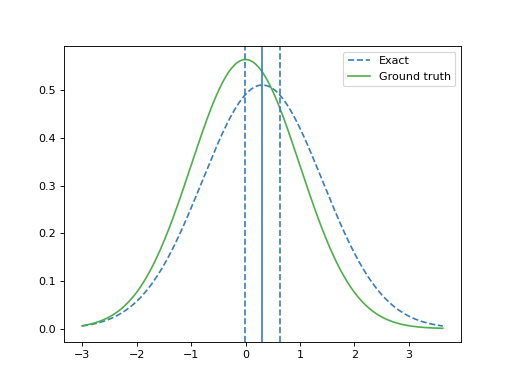

GridspecLayout(children=(interactive(children=(IntSlider(value=50, continuous_update=False, description='N', m…

In [8]:
def exact_solution(data, m0, v0, beta_mean0, beta_var0, iterations=10):
    N = len(data)
    s1 = np.sum(data)
    s2 = np.sum(np.square(data))
    xbar = np.mean(data)
    b0 = beta_var0/beta_mean0
    c0 = (beta_mean0**2)/beta_var0
    
    vN = v0 / (1 + N*v0)
    mN = ((m0/v0) + s1) * vN
    cN = c0 + (N/2)
    d = ((m0**2)/v0) - ((mN**2)/vN) + s2
    bN = 1 / ((1/b0) + d/2)
    beta_mean = bN * cN
    beta_var = (bN**2) * cN
    return mN, vN, beta_mean, beta_var

def update_exact_contour(change):
    ax3.clear()
    mE, vE, beta_meanE, beta_varE = exact_solution(w.value, m0.value, v0.value, beta_mean0.value, beta_var0.value)
    stdE = np.sqrt(1 / beta_meanE)
    x = get_x_range((mE, stdE), (mu.value, std.value))
    exact_contour = get_contours(x, mE, stdE)
    data_contour = get_contours(x, mu.value, std.value)
    plot_contours(ax3,
                  (x, exact_contour, colours["exact"], "Exact", linestyles["exact"]),
                  (x, data_contour, colours["ground_truth"], "Ground truth", linestyles["ground_truth"]))
    bE = beta_varE / beta_meanE
    cE = (beta_meanE**2) / beta_varE
    plot_tramlines(ax3, (mE, np.sqrt(vE / (bE * (cE - 1))), "exact"))

mE, vE, beta_meanE, beta_varE = exact_solution(w.value, m0.value, v0.value, beta_mean0.value, beta_var0.value)
stdE = np.sqrt(1 / beta_meanE)
x = get_x_range((mE, stdE), (mu.value, std.value))
exact_contour = get_contours(x, mE, stdE)
data_contour = get_contours(x, mu.value, std.value)

fig3, ax3 = plt.subplots(num=3)
plot_contours(ax3,
              (x, exact_contour, colours["exact"], "Exact", linestyles["exact"]),
              (x, data_contour, colours["ground_truth"], "Ground truth", linestyles["ground_truth"]))
bE = beta_varE / beta_meanE
cE = (beta_meanE**2) / beta_varE
plot_tramlines(ax3, (mE, np.sqrt(vE / (bE * (cE - 1))), "exact"))

display(grid);

[w.children[n].observe(update_exact_contour, 'value') for n in range(len(w.children))];
[prior_widget.children[n].observe(update_exact_contour, 'value') for n in range(len(prior_widget.children))];

## Variational Bayes

As mentioned above, the exact posterior for a probabilistic model is often intractable. This means that we are often forced to use approximations to enable us to carry out Bayesian inference.

Variational Bayes is a popular algorithm for inferring posterior distributions. It uses the mean field assumption. This means it assumes that the parameters to be estimated are independent of eachother. In our example here, it means we assume the mean and standard deviation of our distribution are independent whereas in our exact solution they covary. If you play around with the values in the sliders making some of the same adjustments as above, you should find it generally performs quite similarly to the exact solution above.

<IPython.core.display.Javascript object>


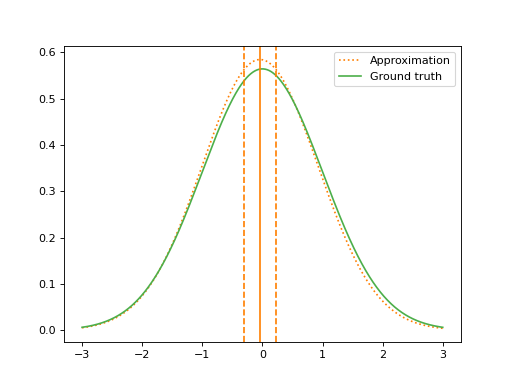

GridspecLayout(children=(interactive(children=(IntSlider(value=50, continuous_update=False, description='N', m…

In [9]:
def vb_solution(data, m0, v0, beta_mean0, beta_var0, iterations=100):
    N = len(data)
    s1 = np.sum(data)
    s2 = np.sum(np.square(data))
    b0 = beta_var0 / beta_mean0
    c0 = (beta_mean0**2)/beta_var0
    m, v, b, c = m0, v0, b0, c0
    for i in range(iterations):
        m = (m0 + v0 * b * c * s1) / (1 + N * v0 * b * c)
        v = v0 / (1 + N * v0 * b * c)
        x = s2 - 2*s1*m + N*(m**2 + v)
        b = 1 / (1/b0 + x/2)
        c = N/2 + c0
    beta_mean = b * c
    beta_var = (b**2) * c
    return m, v, beta_mean, beta_var
    
def update_vb_contour(change):
    ax4.clear()
    mVB, vVB, beta_meanVB, beta_varVB = vb_solution(w.value, m0.value, v0.value, beta_mean0.value, beta_var0.value)
    stdVB = np.sqrt(1 / beta_meanVB)
    x = get_x_range((mVB, stdVB), (mu.value, std.value))
    vb_contour = get_contours(x, mVB, stdVB)
    data_contour = get_contours(x, mu.value, std.value)
    plot_contours(ax4,
                  (x, vb_contour, colours["approx"], "Approximation", linestyles["approx"]),
                  (x, data_contour, colours["ground_truth"], "Ground truth", linestyles["ground_truth"]))
    plot_tramlines(ax4, (mVB, np.sqrt(vVB), "approx"))


        
mVB, vVB, beta_meanVB, beta_varVB = vb_solution(w.value, m0.value, v0.value, beta_mean0.value, beta_var0.value)
stdVB = np.sqrt(1 / beta_meanVB)
x = get_x_range((mVB, stdVB), (mu.value, std.value))
vb_contour = get_contours(x, mVB, stdVB)
data_contour = get_contours(x, mu.value, std.value)

fig4, ax4 = plt.subplots(num=4)
plot_contours(ax4,
              (x, vb_contour, colours["approx"], "Approximation", linestyles["approx"]),
              (x, data_contour, colours["ground_truth"], "Ground truth", linestyles["ground_truth"]))
plot_tramlines(ax4, (mVB, np.sqrt(vVB), "approx"))

display(grid);

[w.children[n].observe(update_vb_contour, 'value') for n in range(len(w.children))];
[prior_widget.children[n].observe(update_vb_contour, 'value') for n in range(len(prior_widget.children))];

# How good is our approximation?

Above, we mentioned that an advantage of this example is that we can compare the quality of fit of the approximate solution with that of the exact solution. In the graph below, we compare the estimates of the mean from both methods as well as our confidence in that mean.

With $N=5$, you should notice that the approximation is generally a little overconfident compared to the exact solution. This can be seen by the approximation's mean distribution having a slightly higher peak and more narrow distribution.

Try slowly increasing the number of samples $N$ from $5$ to $10$, $15$, $20$, $25$ and $50$. You should see that with more data samples, the approximate solution's mean and confidence in that mean gradually approaches that of the exact solution.

<IPython.core.display.Javascript object>


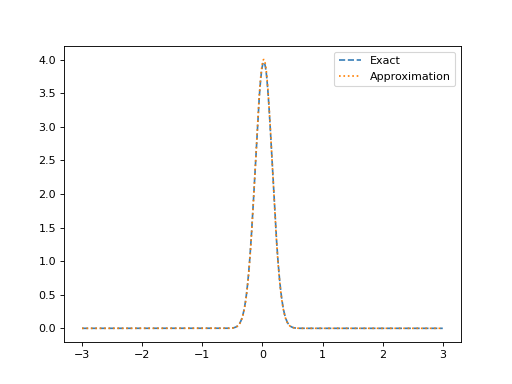

GridspecLayout(children=(interactive(children=(IntSlider(value=50, continuous_update=False, description='N', m…

In [10]:
def get_contour(x, mean, std):
    return (1 / (std * np.sqrt(np.pi))) * np.exp(-0.5 * np.square((x - mean) / std))

def plot_vb_and_exact_contours(ax):
    meanE, standard_devE = [], []
    meanVB, standard_devVB = [], []
    # average over 100 runs
    for i in range(100):
        data = np.random.normal(mu.value, std.value, [N.value])

        # get exact and VB solutions
        mE, vE, beta_meanE, beta_varE = exact_solution(data, m0.value, v0.value, beta_mean0.value, beta_var0.value)
        mVB, vVB, beta_meanVB, beta_varVB = vb_solution(data, m0.value, v0.value, beta_mean0.value, beta_var0.value)
        bE = beta_varE / beta_meanE
        cE = (beta_meanE**2) / beta_varE
        stdE = np.sqrt(vE / (bE * (cE - 1)))
        stdVB = np.sqrt(vVB)
        
        # append to list
        meanE.append(mE)
        standard_devE.append(stdE)
        meanVB.append(mVB)
        standard_devVB.append(stdVB)
        
    # take mean across all runs
    mE, stdE = [np.mean(s) for s in (meanE, standard_devE)]
    mVB, stdVB = [np.mean(s) for s in (meanVB, standard_devVB)]
    
    # get range of points on x-axis
    x = get_x_range((mE, stdE), (mVB, stdVB), (mu.value, std.value))
    
    # get contours
    yE = get_contour(x, mE, stdE)
    yVB = get_contour(x, mVB, stdVB)
    ydata = get_contour(x, mu.value, std.value)
    
    # plot
    plot_contours(ax6,
                  (x, yE, colours["exact"], "Exact", linestyles["exact"]),
                  (x, yVB, colours["approx"], "Approximation", linestyles["approx"]))

def update_contour_plot(change):
    ax6.clear()
    plot_vb_and_exact_contours(ax6)

fig6, ax6 = plt.subplots(num=6)
plot_vb_and_exact_contours(ax6)

display(grid);

[w.children[n].observe(update_contour_plot, 'value') for n in range(len(w.children))];
[prior_widget.children[n].observe(update_contour_plot, 'value') for n in range(len(prior_widget.children))];